# ENSO example notebook

This notebook contains an example of data access of ERA5 data with the `Reader` class and evaluation of the NINO3.4 teleconnection (regional mean) with `aqua` libraries and examples of the plotting routines.

In [1]:
import datetime
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from aqua import Reader
from aqua.slurm import slurm

sys.path.insert(0, '../') # Hack to import from parent directory, to be removed
from index import regional_mean_index, regional_mean_anomalies
from plots import simple_plot, cor_plot, index_plot
from tools import load_namelist

FDB5 binary library not present on system, disabling FDB support.


## Teleconnection details configuration

Details such as teleconnection coordinates are obtained with functions collected in the `tools.py` file, that access details from a `yaml` file. The function `load_namelist` loads data specific to the choosen teleconnection such as coordinates.

Details about the ENSO teleconnection can be accessed by specificing the teleconnection name as a string. The field required to evaluate the teleconnection is also specified in the `namelist`.

## ENSO with ERA5 data

In [2]:
diagname  = 'teleconnections'
telecname = 'ENSO_2t'
exp       = 'ERA5'

namelist = load_namelist(diagname)

field = namelist[telecname]['field']

#slurm.job()

Data required for the teleconnection are retrieved with the `Reader` class from the `AQUA` framework (see framework notebooks for a comprehensive list of examples).

In [3]:
reader = Reader(model='ERA5',exp='era5',source='monthly',regrid='r100')
data = reader.retrieve(var=field)
#data = reader.retrieve()
data

<xarray.Dataset>
Dimensions:  (time: 996, lat: 721, lon: 1440)
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2022-12-01
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * lat      (lat) float64 90.0 89.75 89.5 89.25 ... -89.25 -89.5 -89.75 -90.0
Data variables:
    2t       (time, lat, lon) float32 dask.array<chunksize=(12, 721, 1440), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Thu May 25 12:09:12 2023: cdo -O -s -f nc4 -z zip -shifttim...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

The `Reader` returns a `Dataset`. It is needed to select the data for the desired variable and regrid before calling the library function.

In [4]:
infile = data
infile = reader.regrid(infile)
infile

<xarray.Dataset>
Dimensions:  (time: 996, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1940-01-01 1940-02-01 ... 2022-12-01
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Data variables:
    2t       (time, lat, lon) float64 dask.array<chunksize=(12, 180, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.2.1 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    institution:  European Centre for Medium-Range Weather Forecasts
    history:      Thu May 25 12:09:12 2023: cdo -O -s -f nc4 -z zip -shifttim...
    CDO:          Climate Data Operators version 2.2.0 (https://mpimet.mpg.de...

In [21]:
# Eliminate NaN values
# for i in range(0,len(infile.time)):
#     for j in range(0,len(infile.lat)):
#         for k in range(0,len(infile.lon)):
#             if infile['sst'][i].values[j,k]:
#                 # drop NaN values:
#                 infile['sst'][i].values[j,k] = np.nan
#                 print('NaN found at time',infile.time[i].values,'lat',infile.lat[j].values,'lon',infile.lon[k].values)

## Teleconnection evaluation

The NINO3.4 can be evaluated by using the library function `regional_mean_index` from the `index.py` file.

The teleconnection can be evaluated with a custom rolling window to average data (standard is 3 months, here written explicitely for sake of clarity).

The function returns a `DataArray` with the timeserie of values.

In [13]:
enso = regional_mean_index(field=infile[field],namelist=namelist,telecname=telecname,months_window=3,loglevel='INFO')

2023-06-12 16:41:41 :: regional mean index :: INFO     -> Evaluating regional mean index for ENSO_2t
2023-06-12 16:41:41 :: regional mean index :: INFO     -> Data longitudes are 0-360, converting teleconnection coords
2023-06-12 16:41:41 :: regional mean index :: INFO     -> Region: lon = 190-240, lat = -5-5
2023-06-12 16:42:05 :: regional mean index :: INFO     -> Index evaluated


The timeserie can be plot with the `simple_plot` function from the `plots.py` file, already with some extra optional arguments in order to make a nice plot.

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'ENSO Index, Nino 3.4'}, xlabel='time', ylabel='2 metre temperature [K]'>)

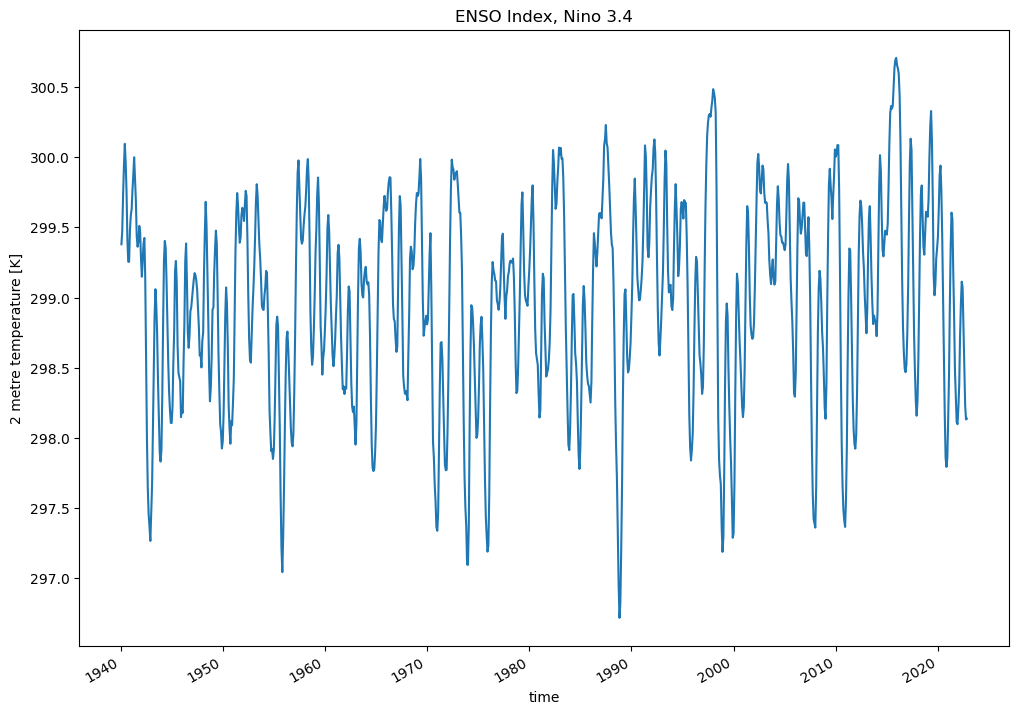

In [14]:
simple_plot(field=enso,title='ENSO Index, Nino 3.4')

## Correlation plot

To visualize the teleconnection on a 2D plot functions in the `plots.py` are introduced.
There is an option `plot=True` that creates a plot of the correlation. Additionally an xarray containing the result of the regression is returned, if needed for further analysis or storage.
A custom projection can be specified.

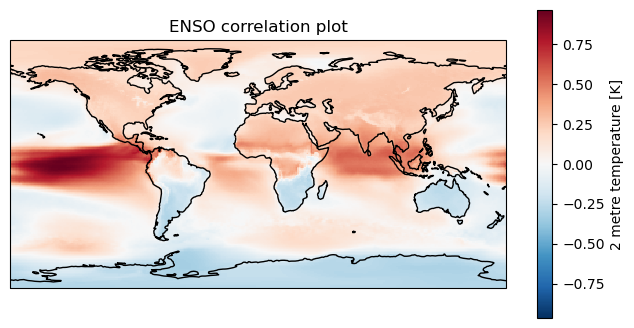

In [24]:
enso_cor = cor_plot(indx=enso,field=infile[field],title='ENSO correlation plot')

## ENSO Nino3.4 anomalies

Another library function is introduced, able to evaluate anomalies of a regional mean index. The function `regional_mean_anomalies` returns a `DataArray` with the anomalies.

Also for this function, an optional parameter `months_window` can be specified to average the data before computing the anomalies.

In [5]:
enso_an = regional_mean_anomalies(field=infile[field],namelist=namelist,telecname=telecname,months_window=3,loglevel='INFO')

2023-06-12 16:36:35 :: regional mean anomalies :: INFO     -> Evaluating regional mean anomalies for ENSO_2t
2023-06-12 16:36:35 :: regional mean anomalies :: INFO     -> Data longitudes are 0-360, converting teleconnection coords
2023-06-12 16:36:35 :: regional mean anomalies :: INFO     -> Region: lon = 190-240, lat = -5-5


/work/bb1153/b382289/mambaforge/envs/teleconnections/lib/python3.10/site-packages/xarray/core/indexing.py:1443: PerformanceWarning: Slicing with an out-of-order index is generating 83 times more chunks
  return self.array[key]
2023-06-12 16:36:35 :: regional mean anomalies :: INFO     -> Index evaluated


The timeserie can be plot with the `index_plot` function from the `plots.py` file, already with some customization in order to make a nice plot.

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'ENSO Anomalies, Nino 3.4'}, xlabel='time', ylabel='2 metre temperature [K]'>)

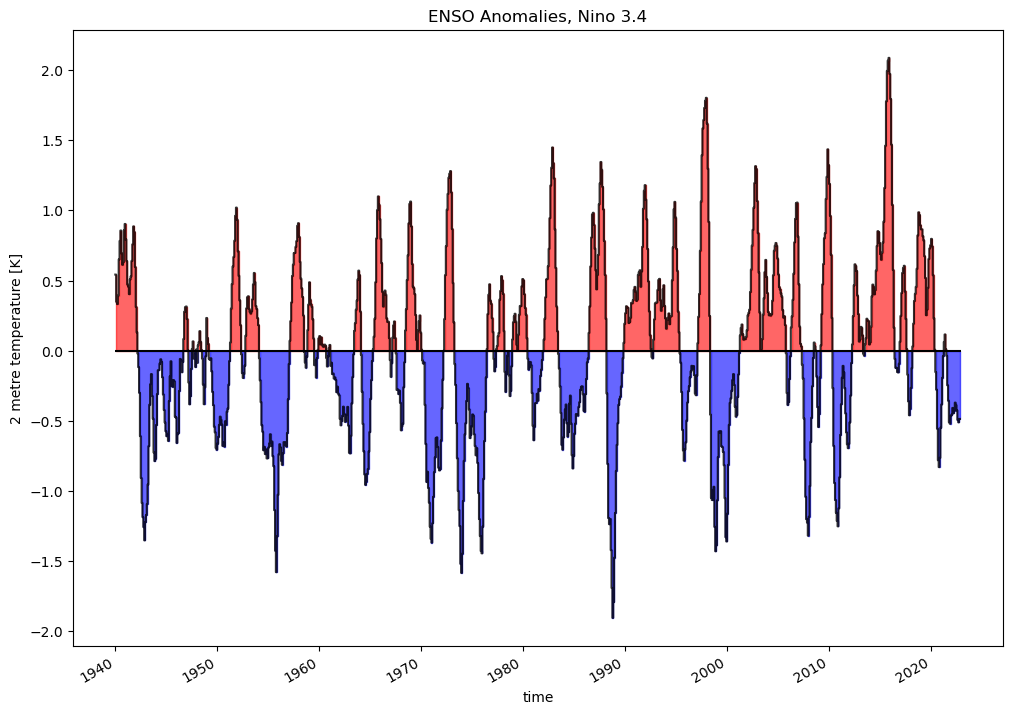

In [6]:
index_plot(enso_an,title='ENSO Anomalies, Nino 3.4')

## NCAR comparison

With the NINO3.4 anomalies and monthly data computed, we can compare with observational data from NCAR, to check if the index is computed correctly.

In [7]:
ncar_path = '../data/nina34.anom.txt'
enso_ncar = np.genfromtxt(ncar_path,skip_header=3,skip_footer=4)

# If some missing value is remaining
for i in enso_ncar:
    for j in i:
        if j == -99.99:
            j = np.nan

year = enso_ncar[:,0]
month_data = enso_ncar[:, 1:]
time = xr.cftime_range(start=str(int(year[0])),periods=12*len(year),freq='MS',calendar='standard')
month_data = month_data.reshape(-1)
enso_ncar = xr.DataArray(month_data, coords=[time], dims=['time'], name='monthly_data')

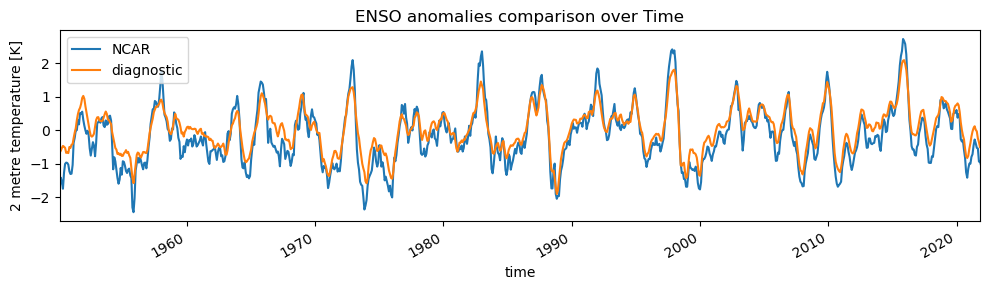

In [9]:
time_vals = np.array(time.values)

# Convert to datetime objects
datetimes = [np.datetime64(t).astype(datetime.datetime) for t in time_vals]

# Plot with matplotlib
fig = plt.figure(figsize=(10,3))
plt.plot(datetimes, enso_ncar.values,label='NCAR')

plt.xlim(datetime.datetime(1950, 1, 31, 0, 0),datetime.datetime(2021, 10, 31, 0, 0))

enso_an.plot(label='diagnostic')
plt.legend()
plt.title('ENSO anomalies comparison over Time')
fig.tight_layout()
plt.show()

In [11]:
ncar_path = '../data/nina34.txt'
enso_ncar = np.genfromtxt(ncar_path,skip_header=3,skip_footer=4)

year = enso_ncar[:,0]
month_data = enso_ncar[:, 1:]
time = xr.cftime_range(start=str(int(year[0])),periods=12*len(year),freq='MS',calendar='standard')
month_data = month_data.reshape(-1)
enso_ncar = xr.DataArray(month_data, coords=[time], dims=['time'], name='monthly_data')

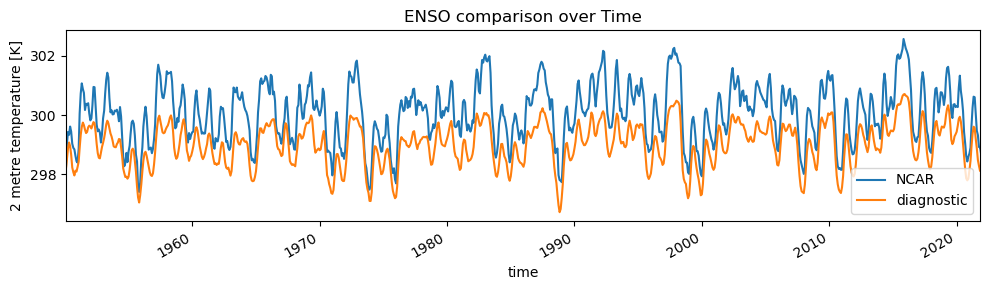

In [15]:
time_vals = np.array(time.values)

# Convert to datetime objects
datetimes = [np.datetime64(t).astype(datetime.datetime) for t in time_vals]

# Plot with matplotlib
fig = plt.figure(figsize=(10,3))
plt.plot(datetimes, enso_ncar.values+273.15,label='NCAR')

plt.xlim(datetime.datetime(1950, 1, 31, 0, 0),datetime.datetime(2021, 10, 31, 0, 0))

enso.plot(label='diagnostic')
plt.legend()
plt.title('ENSO comparison over Time')
fig.tight_layout()
plt.show()